<a href="https://colab.research.google.com/github/mwbest/MBestWeb/blob/main/NGC6569_GalaTutorialTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This is a colab-optimized version of the Gala tutorial at this location: http://gala.adrian.pw/en/latest/dynamics/mockstreams.html*





## **Imports**

In [23]:
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d # for 3D plots
import plotly.express as px 

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord

!pip install gala
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install astroquery
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Default Astropy Galactocentric frame parameters** (*Graphic preferences found in [this file](https://github.com/adrn/gala/blob/main/docs/tutorials/nb_setup))*

In [24]:
import matplotlib.pyplot as plt
!pip install cmastro
from cmastro import cmaps  # noqa

plt.style.use("default")

# NOTE: if you update these, also update docs/conf.py
plot_rcparams = {
    'image.cmap': 'cma:hesperia',

    # Fonts:
    'font.size': 8,
    'figure.titlesize': 'x-large',
    'figure.figsize': '4,4',
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',

    # Axes:
    'axes.labelcolor': 'k',
    'axes.axisbelow': True,

    # Ticks
    'xtick.color': '#333333',
    'xtick.direction': 'in',
    'ytick.color': '#333333',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,

    'figure.dpi': 100,
    'savefig.dpi': 300,
}

plt.rcParams.update(plot_rcparams)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will also set the default Astropy Galactocentric frame parameters to the values adopted in Astropy v4.0:

In [25]:
import astropy.coordinates as coord
_ = coord.galactocentric_frame_defaults.set('v4.0')

All mock stream generation done using the built-in gravitational potential models implemented in gala.potential, so we must first specify a gravitational potential to integrate orbits in. For the examples below, we will use a spherical NFW potential with a circular velocity at the scale radius of 220 km/s, and a scale radius of 15 kpc:

In [26]:
pot = gp.NFWPotential.from_circular_velocity(v_c=220*u.km/u.s,
                                             r_s=15*u.kpc,
                                             units=galactic)


The mock stream generation supports any of the reference frames implemented in gala (e.g., non-static / rotating reference frames), so we must create a Hamiltonian object to use when generating streams. By default, this will use a static reference frame:

In [27]:
H = gp.Hamiltonian(pot)

Next, we will create initial conditions for the progenitor system. In this case, we will generate the mock stream starting from this position going forward in time. 

However, this is customizable: if you instead have the final position of the progenitor system, there is a convenient way of doing this described below (see [Generating a stream from the present-day progenitor location](http://gala.adrian.pw/en/latest/dynamics/mockstreams.html#gala-mockstream-final-conditions) ). 

Let’s specify a position and velocity that we think will produce a mildly eccentric orbit in the x-y plane of our coordinate system:

In [28]:
prog_w0 = gd.PhaseSpacePosition(pos=[10, 0, 0.] * u.kpc,
                                vel=[0, 170, 0.] * u.km/u.s)


We now have to specify the method for generating stream particles, i.e., the stream distribution function (DF). For this example, we will use the method implemented in [fardal15], incuded in gala as FardalStreamDF. Other methods of note are StreaklineStreamDF from [kuepper12], and LagrangeCloudStreamDF based on [gibbons14]. Each of the StreamDF classes take a few common arguments, such as lead and trail, which are boolean arguments that control whether to generate both leading and trailing tails, or just one or the other. By default, both are set to True (i.e., both leading and trailing tails are generated by default). Some other StreamDF classes may require other parameters. Let’s create a FardalStreamDF instance and accept the default argument values. We will also need to specify the progenitor mass, which is passed in to any StreamDF and is used to scale the particle release distribution:

In [29]:
df = ms.FardalStreamDF()
prog_mass = 2.5E4 * u.Msun

The final step before actually generating the stream is to create a MockStreamGenerator instance, which we will use to actually generate the stream. This takes the StreamDF and the external potential (Hamiltonian) as arguments:

In [30]:
gen = ms.MockStreamGenerator(df, H)


## **NGC 6569 information**

*Ra, dec, pmra, pmdec: [Vasiliev et al., 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5978V/abstract) on Table A1.*

*Mass, distance, radial vel: [this website](https://people.smp.uq.edu.au/HolgerBaumgardt/globular/fits/ngc6558.html).*

Change these values if we obtain better data!

In [45]:
NGC6569 = coord.SkyCoord(ra = 273.412*u.degree, dec = -31.827*u.degree,
                        distance=(10.5)*u.kpc,
                        pm_ra_cosdec= -4.125*u.mas/u.yr,
                        pm_dec= -7.354*u.mas/u.yr,
                        radial_velocity= -49.82*u.km/u.s)
NGC6569_rep = NGC6569.transform_to(coord.Galactocentric).data
NGC6569_w0 = gd.PhaseSpacePosition(NGC6569_rep)
NGC6569_mass = 2.6e4 * u.Msun


# Choosing either Plummer or Stone potential
NGC6569_pot = gp.PlummerPotential(m=NGC6569_mass, b=4*u.pc, units=galactic)
#NGC6569_pot = gp.StonePotential(m=NGC6569_mass, r_c=0.4*u.pc, r_h=2.62*u.pc, units=galactic)
mw = gp.MilkyWayPotential()


gen_NGC6569 = ms.MockStreamGenerator(df, mw, progenitor_potential=NGC6569_pot)
NGC6569_stream, _ = gen_NGC6569.run(NGC6569_w0, NGC6569_mass,
                              dt=-0.5 * u.Myr, n_steps=500)
NGC6569_stream_c = NGC6569_stream.to_coord_frame(coord.ICRS)
#Generate a stream from the cluster location, releasing at time dt for n_steps.

## **Downloading data**

In [32]:
#Downloading the stream data.

from google.colab import files
from astropy.table import Table
import pandas as pd

coord_df = pd.DataFrame({"RA": NGC6569_stream_c.ra.degree, "Dec": NGC6569_stream_c.dec.degree, 
                          "RV": NGC6569_stream_c.radial_velocity, "pm_ra": NGC6569_stream_c.pm_ra_cosdec, 
                          "pm_dec": NGC6569_stream_c.pm_dec})
t1 = Table.from_pandas(coord_df)

t1.write("file.csv", overwrite=True)
files.download("file.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# Downloading the release time.

# NGC6569_stream.release_time.value

# releaseTimeList = []

# for i in NGC6569_stream.release_time:
#   releaseTimeList.append(i)

# print(releaseTimeList)

# from google.colab import files
# from astropy.table import Table
# import pandas as pd

# df = pd.DataFrame(
#     releaseTimeList, columns=["Release Time"])
# print(df)

# t2 = Table.from_pandas(df)

# t2.write("file.csv", overwrite=True)
# files.download("file.csv")



# **Plots**



## Declination vs Right Ascension

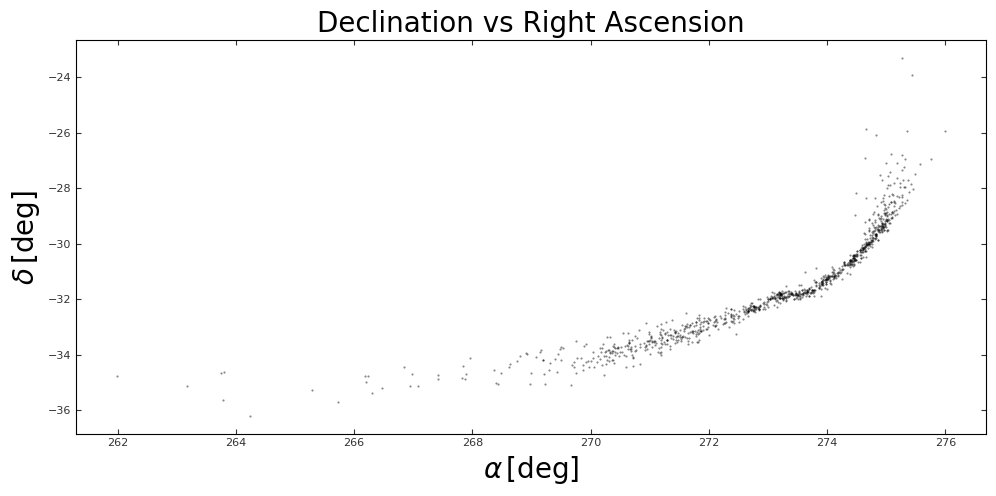

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

axes.scatter(NGC6569_stream_c.ra.degree,
                   NGC6569_stream_c.dec.degree, color = 'k', marker='.', s=1, alpha=0.5)

plt.title("Declination vs Right Ascension", fontsize = 20)

axes.set_xlabel(r'$\alpha\,[{\rm deg}]$', fontsize = 20)
axes.set_ylabel(r'$\delta\,[{\rm deg}]$', fontsize = 20)

fig.tight_layout()

## Radial Velocity vs Right Ascension

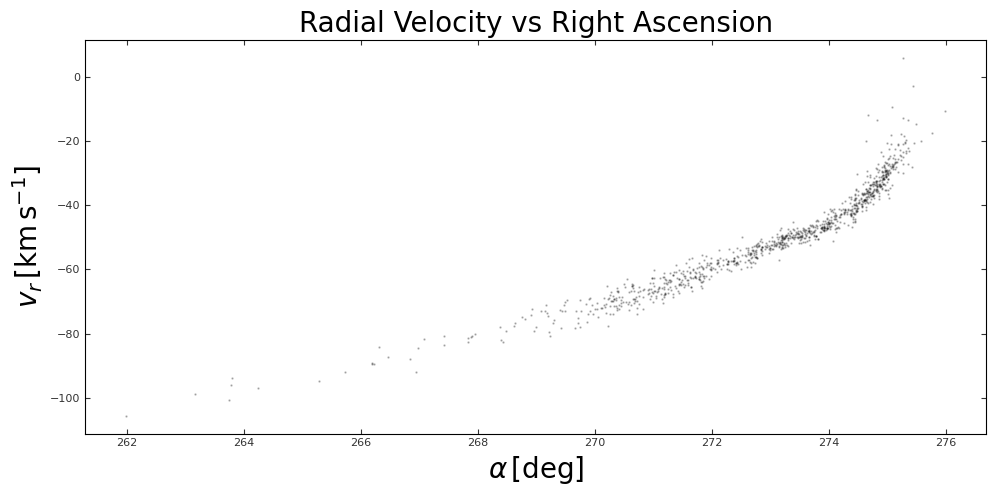

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

axes.scatter(NGC6569_stream_c.ra.degree,
                   NGC6569_stream_c.radial_velocity.to(u.km/u.s), marker='.', s=2, alpha=0.25, color='k')

plt.title("Radial Velocity vs Right Ascension", fontsize = 20)

axes.set_xlabel(r'$\alpha\,[{\rm deg}]$', fontsize = 20)
axes.set_ylabel(r'$v_r\,[{\rm km}\,{\rm s}^{-1}]$', fontsize = 20)

fig.tight_layout()

## Y vs X; Z vs X; Z vs Y







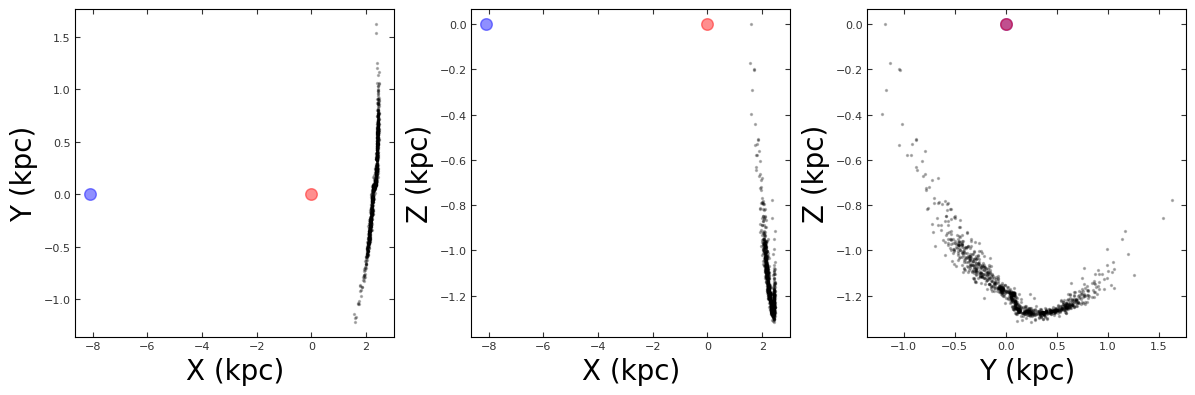

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

axes[0].scatter(NGC6569_stream.x,
                   NGC6569_stream.y, marker='o', s=2, alpha=0.25, color='k')

axes[0].scatter([-8.1,-8.1], [0,0], marker='o', s=70, alpha=0.25, color='blue')
axes[0].scatter([0,0], [0,0], marker='o', s=70, alpha=0.25, color='red')

axes[1].scatter(NGC6569_stream.x,
                   NGC6569_stream.z, marker='o', s=2, alpha=0.25, color='k')

axes[1].scatter([-8.1,-8.1], [0,0], marker='o', s=70, alpha=0.25, color='blue')
axes[1].scatter([0,0], [0,0], marker='o', s=70, alpha=0.25, color='red')

axes[2].scatter(NGC6569_stream.y,
                   NGC6569_stream.z, marker='o', s=2, alpha=0.25, color='k')

axes[2].scatter([0,0], [0,0], marker='o', s=70, alpha=0.25, color='blue')
axes[2].scatter([0,0], [0,0], marker='o', s=70, alpha=0.25, color='red')

axes[0].set_xlabel(r'X (kpc)', fontsize = 20)
axes[1].set_xlabel(r'X (kpc)', fontsize = 20)
axes[2].set_xlabel(r'Y (kpc)', fontsize = 20)
axes[0].set_ylabel(r'Y (kpc)', fontsize = 20)
axes[1].set_ylabel(r'Z (kpc)', fontsize = 20)
axes[2].set_ylabel(r'Z (kpc)', fontsize = 20)

fig.tight_layout()

###    **Y vs X; Z vs X; Z vs Y (zoom)**







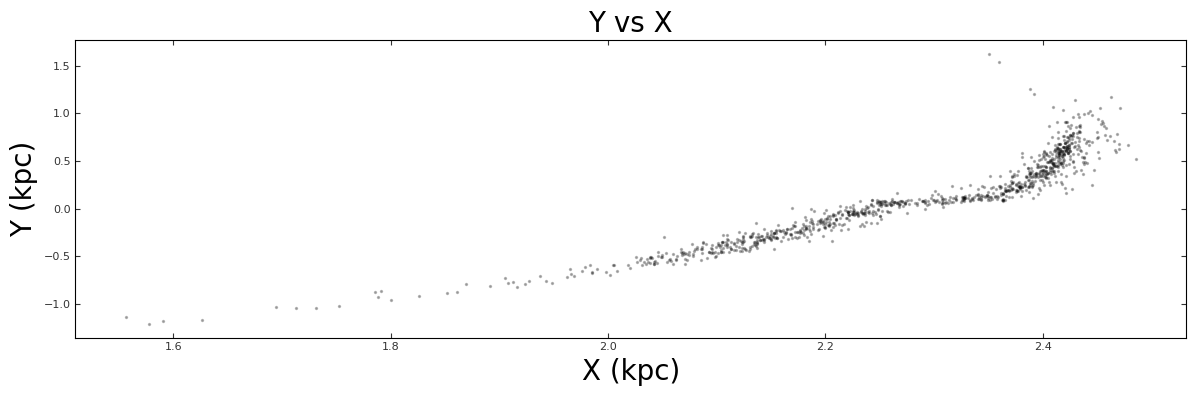

In [49]:
fig, axes = plt.subplots(1, 1, figsize=(12,4))

axes.scatter(NGC6569_stream.x,
                   NGC6569_stream.y, marker='o', s=2, alpha=0.25, color='k')

plt.title("Y vs X", fontsize = 20)

axes.set_xlabel(r'X (kpc)', fontsize = 20)
axes.set_ylabel(r'Y (kpc)', fontsize = 20)

fig.tight_layout()

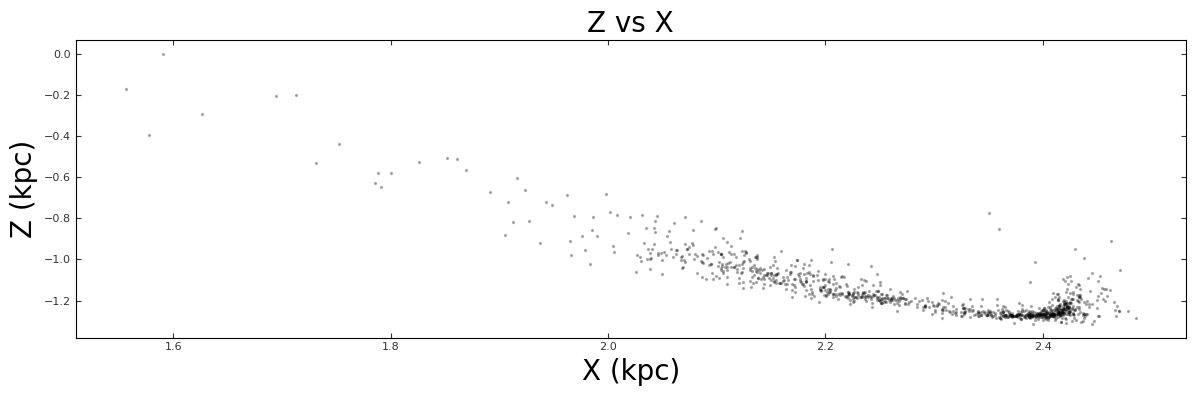

In [50]:
fig, axes = plt.subplots(1, 1, figsize=(12,4))

axes.scatter(NGC6569_stream.x,
                   NGC6569_stream.z, marker='o', s=2, alpha=0.25, color='k')

plt.title("Z vs X", fontsize = 20)

axes.set_xlabel(r'X (kpc)', fontsize = 20)
axes.set_ylabel(r'Z (kpc)', fontsize = 20)

fig.tight_layout()

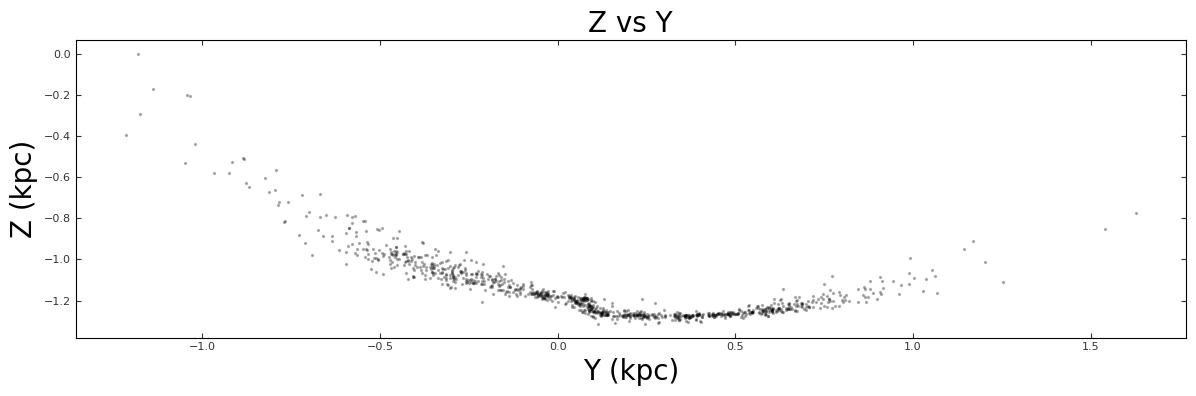

In [51]:
fig, axes = plt.subplots(1, 1, figsize=(12,4))

axes.scatter(NGC6569_stream.y,
                   NGC6569_stream.z, marker='o', s=2, alpha=0.25, color='k')

plt.title("Z vs Y", fontsize = 20)

axes.set_xlabel(r'Y (kpc)', fontsize = 20)
axes.set_ylabel(r'Z (kpc)', fontsize = 20)

fig.tight_layout()

## Proper Motion in Right Ascension vs Proper Motion in Declination



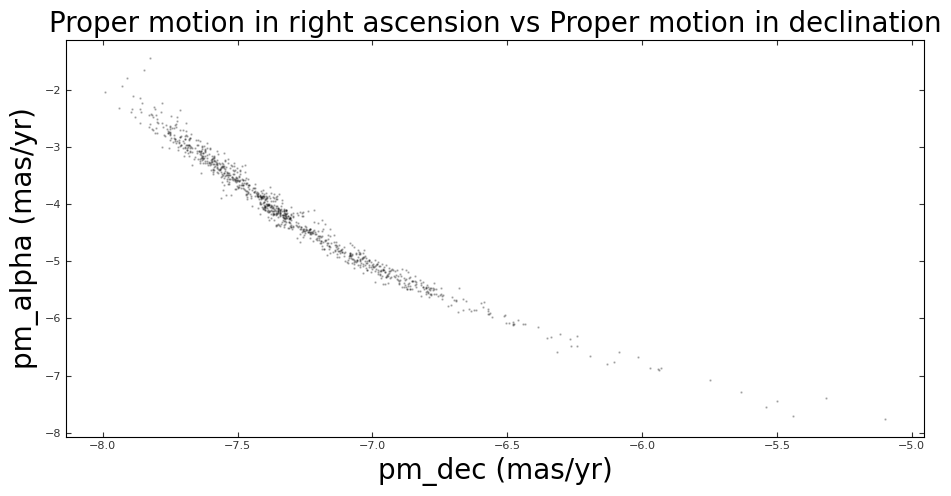

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

plt.title("Proper motion in right ascension vs Proper motion in declination", fontsize = 20)

axes.scatter(NGC6569_stream_c.pm_dec,
                   NGC6569_stream_c.pm_ra_cosdec, marker='.', s=2, alpha=0.25, color='k')

axes.set_ylabel(r'pm_alpha (mas/yr)', fontsize = 20)
axes.set_xlabel(r'pm_dec (mas/yr)', fontsize = 20)

fig.tight_layout()

## Proper Motion in Right Ascension vs Right Ascension

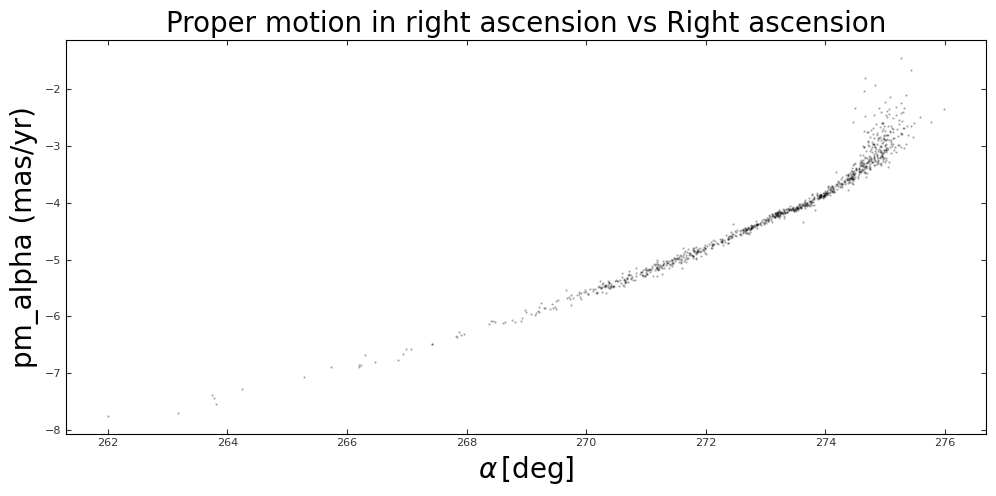

In [53]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

plt.title("Proper motion in right ascension vs Right ascension", fontsize = 20)

axes.scatter(NGC6569_stream_c.ra.degree,
                   NGC6569_stream_c.pm_ra_cosdec, marker='.', s=2, alpha=0.25, color='k')

axes.set_ylabel(r'pm_alpha (mas/yr)', fontsize = 20)
axes.set_xlabel(r'$\alpha\,[{\rm deg}]$', fontsize = 20)

fig.tight_layout()

## Proper Motion in Declination vs Right Ascension

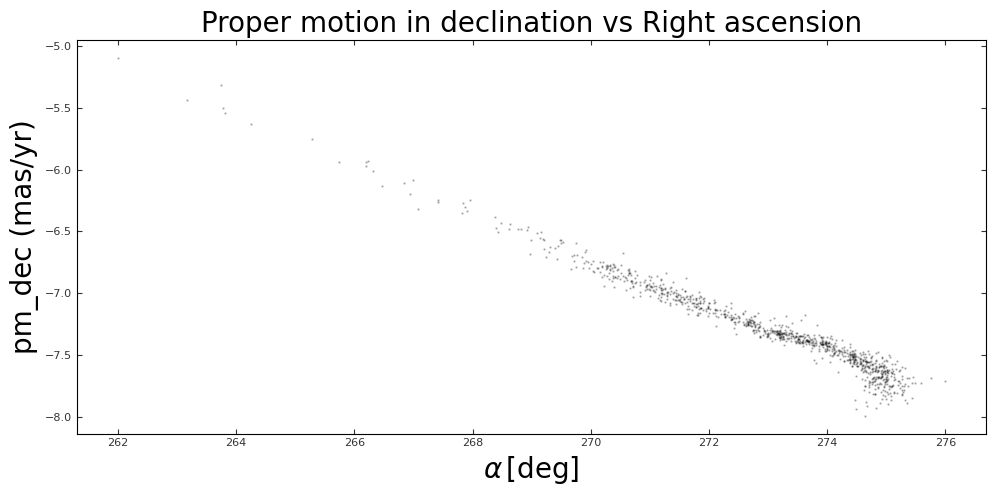

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

plt.title("Proper motion in declination vs Right ascension", fontsize = 20)

axes.scatter(NGC6569_stream_c.ra.degree,
                   NGC6569_stream_c.pm_dec, marker='.', s=2, alpha=0.25, color='k')

axes.set_ylabel(r'pm_dec (mas/yr)', fontsize = 20)
axes.set_xlabel(r'$\alpha\,[{\rm deg}]$', fontsize = 20)

fig.tight_layout()         

# **Interactive 3D plot**

In [55]:
fig = px.scatter_3d(x = NGC6569_stream.x, y = NGC6569_stream.y, z = NGC6569_stream.z, width  = 1000, height = 1000)
fig.update_traces(marker = dict(size = 2, color = 'DarkSlateGrey'), selector = dict(mode = 'markers'))